# Pseudospectral tutorial, part 2
## Les Houches, summer 2017


A gentle stroll through pseudospectral methods: solving $\partial_t q + \textrm{J}(\psi, q) = \nu \nabla^2q$, where $q = \nabla^2\psi$.



First load the package for plotting.

In [1]:
using Pkg
Pkg.activate("../../.")

using PyPlot, FFTW

We create the physical grid $x$, $y$ (as in the Differentiation notebook). Also, we create the wavenumber grid.

In [2]:
nx, ny = 128, 128            # number of grid points
Lx, Ly = 2*pi, 2*pi      # size of the domain in each direction

# constructing the physical grid (x, y)
dx, dy = Lx/nx, Ly/ny
 x = 0:dx:Lx-dx
 y = 0:dy:Ly-dy

X  = zeros(nx, ny)
Y  = zeros(nx, ny)
for j in 1:ny, i in 1:nx
     X[i, j] = x[i]
     Y[i, j] = y[j]
end

# constructing the wavenumber grid (k, l)
k  = 2*pi/Lx * [0:nx/2; -nx/2+1:-1]
l  = 2*pi/Ly * [0:ny/2; -ny/2+1:-1]

K = zeros(nx, ny)
L = zeros(nx, ny)
for j in 1:ny, i in 1:nx
    K[i, j] = k[i]
    L[i, j] = l[j]
end

ksq = K.^2 + L.^2

invksq = 1 ./ ksq
invksq[1, 1] = 1;

Let's define some parameters.

In [3]:
nu = 8.0e-5       # diffusion coefficient
dt = 0.01         # the time stem
tfin = 50         # the final time
nstep  = Int(tfin/dt) + 1;  # the total number of time steps

t = 0:dt:tfin;

Prescribe an initial condition for $\zeta$ and plot it.

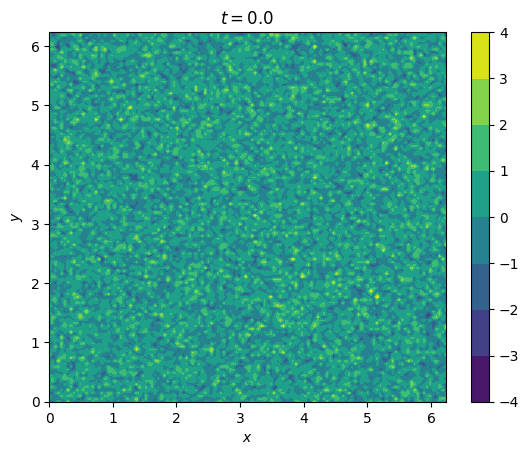

In [4]:
q0 = randn(nx, ny)
qh = fft(q0)
q0 = real(ifft(qh))

j=1

time = t[j]
figure(1)
contourf(X, Y, q0)
xlabel(L"$x$")
ylabel(L"$y$")
title("\$t = $time \$")
colorbar()
draw();

Time-step $\zeta$ forward for $nstep$ times. Notice that we use the conservative form: $\nabla\cdot(\mathbf{u}q)$ instead of $\mathbf{u}\cdot\nabla q$.

In [5]:
for j = 2:nstep
    
    psih = -invksq.*qh              # calculate \hat{\psi}
    q =  real(ifft(qh))             # calculate q(x,y,t)
    u = -real(ifft(im*L.*psih))     # calculate zonal velocity u(x,y,t)
    v =  real(ifft(im*K.*psih))     # calculate meridional velocity v(x,y,t)

    # now we are ready to calculate the r.h.s. of our PDE
    # notice that we use the conservative form of the Jacobian
    rhs = -im*K.*fft(u.*q) -im*L.*fft(v.*q) - nu*ksq.*qh 
    
    qh = qh + dt*rhs         # time-step forward using the simplest Euler scheme
end

Plot the final state.

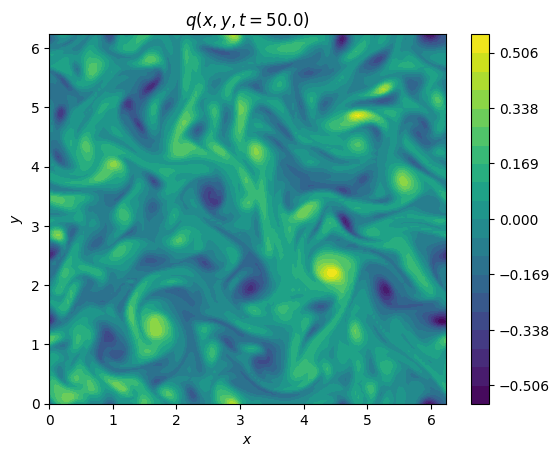

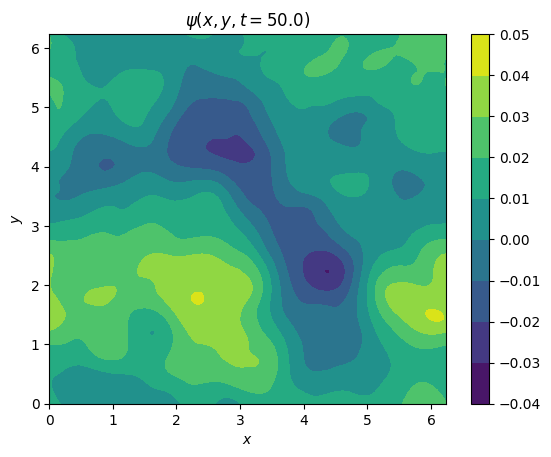

In [9]:
time = t[nstep]
   q = real(ifft(qh))
 psi = real(ifft(-invksq.*qh))
maxq = maximum(abs.(q))
levs = range(-maxq, maxq, length=21)


fig = figure(1)
contourf(X, Y, q, levs)
title(string(L"$q(x, y, t = ", time, L")$"))
xlabel(L"$x$")
ylabel(L"$y$")
draw()
colorbar();

fig = figure(2)
contourf(X, Y, psi)
title(string(L"$\psi(x, y, t = ", time, L")$"))

xlabel(L"$x$")
ylabel(L"$y$")
draw()
colorbar();

**Exercise**: Improve this code so that you approach the quality of the video that Bill showed in his lecture 2. For example:

1. Try using a better time-stepping scheme. For example, Runge-Kutta 4th order, or Adams–Bashforth 3rd order, or solve for the linear dynamics (here only the $\nu \nabla^2 q$ term) explicitly using exponential integrators (e.g., [ETDRK4](https://github.com/navidcy/ETDRK4_notes)).

2. Try using higher-order viscocity so that the small wavenumber are less damped and thus  better approach the inviscid limit, for example $(-1)^{h+1}\nu \nabla^{2h} q$. (For $h=1$ this is just bare Navier-Stokes viscosity.)

3. Try implementing dealiasing in the code. Some notes on dealiasing can be found [here](http://pauli.uni-muenster.de/tp/fileadmin/lehre/NumMethoden/SS16/pseudospectral.pdf).

4. Try adding the $\beta\partial_x\psi$ term and see if you get some zonal jets.